## Concrete Strength Prediction Project

In [1]:
####################################################################
#PROJECT NAME: Concrete Strength Prediction Project                #    
#                                                                  #
#                                                                  #                    
#PROGRAM NAME: Concrete_Strength_Prediction_Project                #                                                               #
#AUTHOR:     Kevin Kluck                                           #
#DATE:       8/16/2020                                             #
#                                                                  #
#Python Version:3.7.6                                              #      
#                                                                  #
#                                                                  #         
#ABSTRACT:To predict the concrete strength using the data          #
#         available in the file concrete_data.xls. Apply feature   #
#        engineering and model tuning to obtain 80% to 95%         #
#        of R2score.                                               #
####################################################################


In [2]:
##############################
##                          ##
##      Import Libraries    ##
##                          ##
##############################

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import warnings
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer  
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 


warnings.filterwarnings("ignore")

Data is from https://archive.ics.uci.edu/ml/machine-learningdatabases/concrete/compressive/. I would like to thank Professor I-Cheng Yeh, from the Department of Information Management at Chung-Hua University, for putting together this data.

In [3]:
##############################
##                          ##
##      Import Data         ##
##                          ##
##############################



df = pd.read_csv("concrete.csv") 



############# python formating ##################
extra = {'Bold': '\x1b[1m',
        'Underline': '\x1b[4m',
        'Blue': '\x1b[94m',
        'End': '\x1b[0m'}

seed = 1729

## Exploratory Data Quality Report 

#### Univariate analysis 

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [5]:
print(extra['Bold'],extra['Blue'],extra['Underline'],"\nData Types")
print("\n")
print(extra['End'],df.dtypes)

print(extra['Bold'],extra['Blue'],extra['Underline'],"\nShape")
print("\n")
print(extra['End'],df.shape)

print(extra['Bold'],extra['Blue'],extra['Underline'],"\nNumber of Missing Values per Column")
print("\n")
print(extra['End'],df.isnull().sum())

print(extra['Bold'],extra['Blue'],extra['Underline'],"\nNumber of Unique Values per Column")
print("\n")
print(extra['End'],df.nunique())

print(extra['Bold'],extra['Blue'],extra['Underline'],"\nRanges of Numerical Data")
print(extra['End'])
print(df.max()-df.min())

print(extra['Bold'],extra['Blue'],extra['Underline'],"\nStatistical Summary")
print(extra['End'])
df.describe()


   
Data Types


 cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object
   
Shape


 (1030, 9)
   
Number of Missing Values per Column


 cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64
   
Number of Unique Values per Column


 cement          278
slag            185
ash             156
water           195
superplastic    111
coarseagg       284
fineagg         302
age              14
strength        845
dtype: int64
   
Ranges of Numerical Data

cement          438.00
slag            359.40
ash             200.10
water           125.20
superplastic     32.20
coarseagg       344.00
fineagg         398.60
age             364.00
strength         80.27
dtype: float64
   
Statistical Summary


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


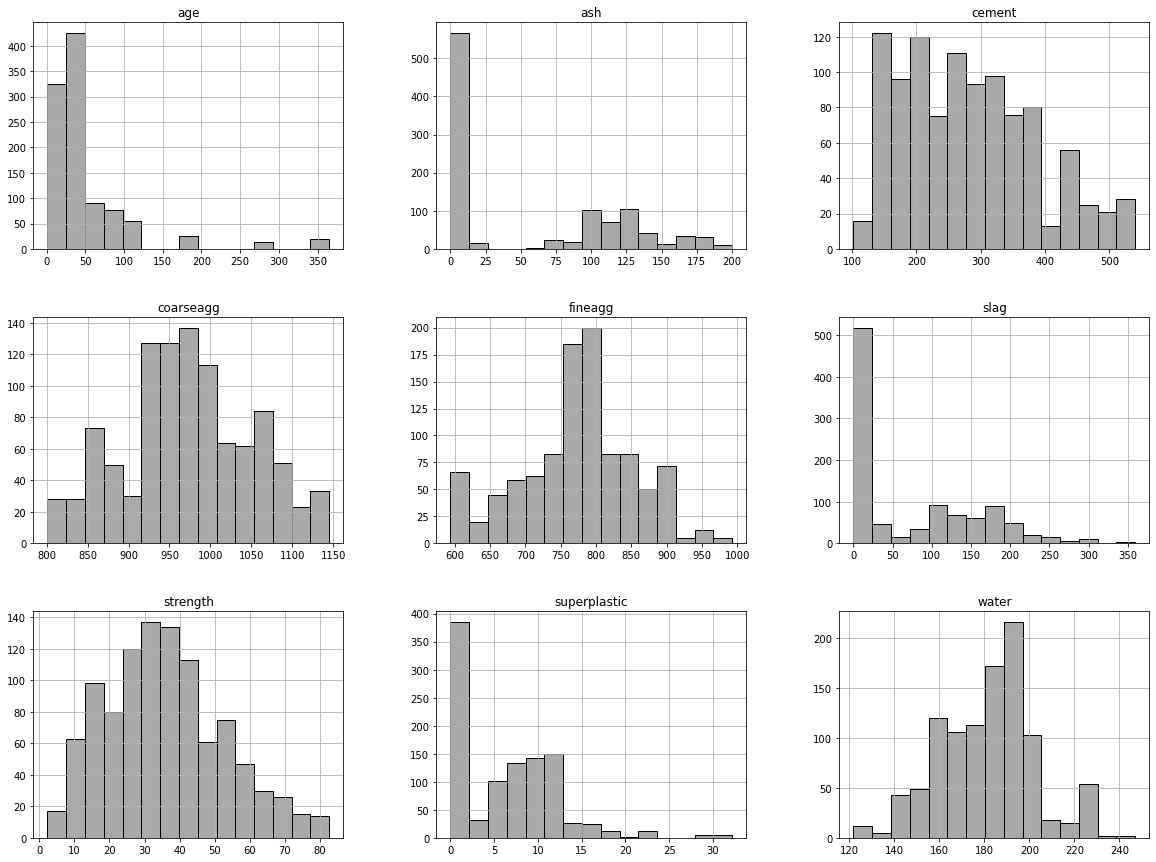

In [6]:
df.hist(bins=15, figsize=(20, 15), layout=(3, 3), color = 'darkgray', edgecolor='black');

In [7]:
def find_upper_n(a):
    Upper = df[a].quantile(0.75)+1.5*(df[a].quantile(0.75)-df[a].quantile(0.25))
    number1 = len(df[(df[a]>Upper)])
    print('Number of observations that have',a,'above', round(Upper,0), ':', number1,"(",round(number1/len(df)*100,1),"%",")")
    print("\n")
    return

find_upper_n('age')
find_upper_n('ash')
find_upper_n('fineagg')
find_upper_n('superplastic')
find_upper_n('slag')
find_upper_n('water')

Upper_dur = df['water'].mean()+ 3*df['water'].std()
number2 = len(df[(df['water']>Upper_dur)])
print('Number of clients that have water above 3 sd from the mean,', round(Upper_dur,0), ':', number2)


Number of observations that have age above 130.0 : 59 ( 5.7 % )


Number of observations that have ash above 296.0 : 0 ( 0.0 % )


Number of observations that have fineagg above 964.0 : 5 ( 0.5 % )


Number of observations that have superplastic above 26.0 : 10 ( 1.0 % )


Number of observations that have slag above 357.0 : 2 ( 0.2 % )


Number of observations that have water above 233.0 : 4 ( 0.4 % )


Number of clients that have water above 3 sd from the mean, 246.0 : 2


In [8]:
def missed(a):
    miss = len(df[(df[a] == 0)])
    print('Number of observations that have 0 value for',a, ':', miss)
    print("\n")
    return
missed('age')
missed('ash')
missed('superplastic')
missed('slag')



Number of observations that have 0 value for age : 0


Number of observations that have 0 value for ash : 566


Number of observations that have 0 value for superplastic : 379


Number of observations that have 0 value for slag : 471




Description:

Cement is measured in kg. The distribution is slightly skewed right.

The attribute Slag, which is value for Blast Furnace Slag in Kg. Slag is heavily skewed right, there are 2 observations that are consider outliers. There are no missing values but there are 471 observations that have a value of 0.

Ash, which is fly ash measured in kg. Ash is heavily skewed right, there are no outliers. There are no missing values but there are 566 observations that have a value of 0.

Water is measured in kg. The distribution is normal. There are 2 outliers that are more than 3 sd from the mean.

Superplastic, which is superplasticizer measured in kg. The distribution is heavily skewed right. There are 10 values that are outliers. There are 379 observations that have a value of 0. 

Coarseagg, which is coarse aggregate is measured in kg. Distribution seems to be normal.

Fineagg, which is fine aggregated measure in kg, distribution seems to be normal. There are 5 values that seem to be outliers.

Age represents number of days. Distribution looks heavily skewed to the right. There are 59 values that seem to be outliers.

Strength, concrete compressive strength which is measured in MPa. Distribution looks normal with a lightly skewness to the right.


#### Bi-variate analysis 

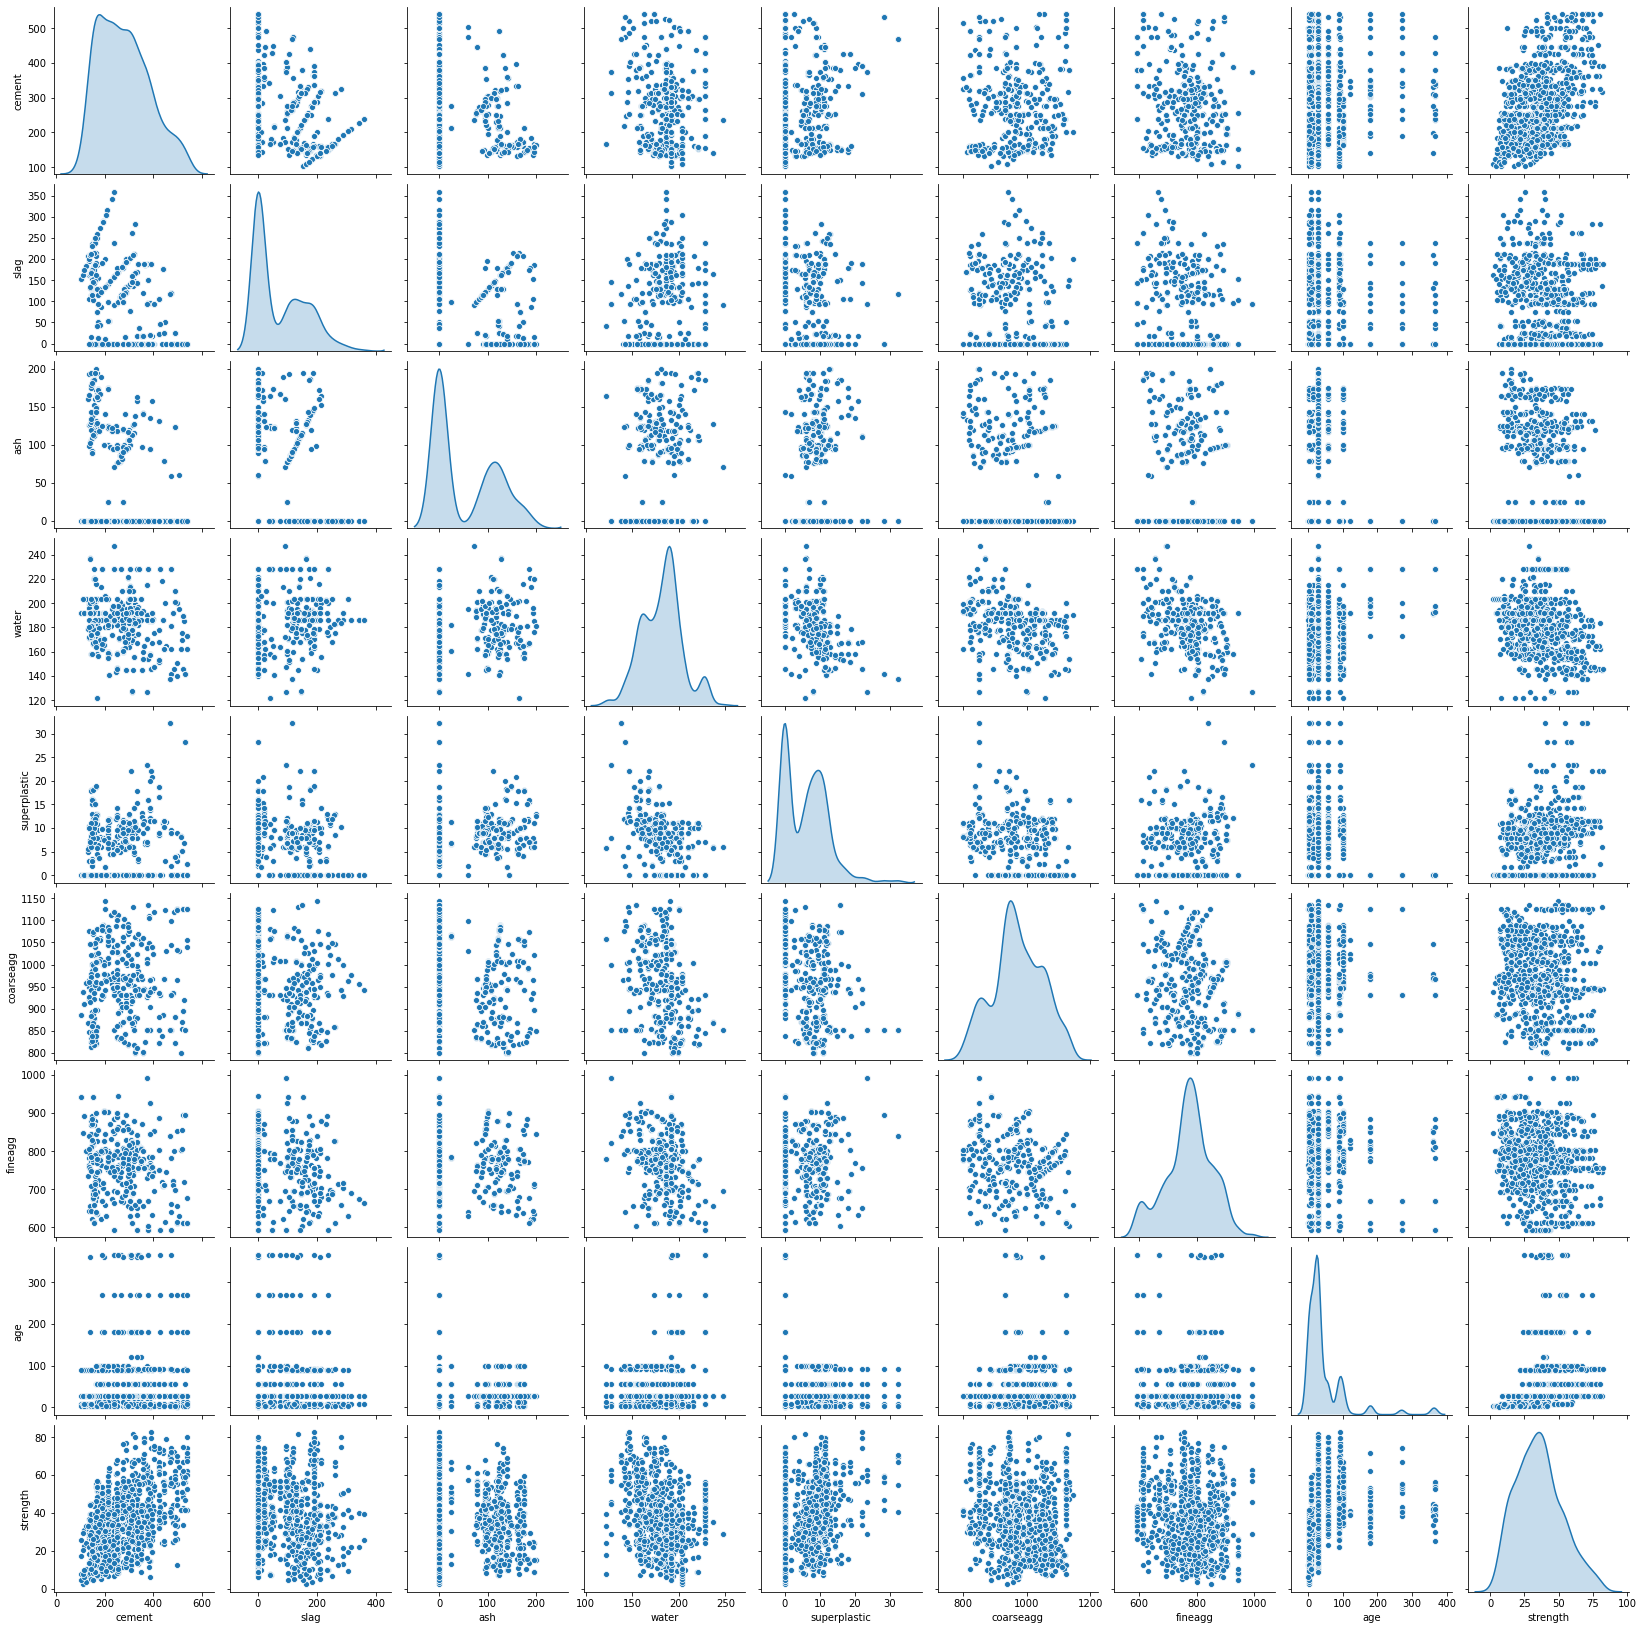

In [9]:
sns.pairplot(df, diag_kind = 'kde')
plt.show()

Text(0.5, 1, 'CORRELATION BETWEEN VARIABLES')

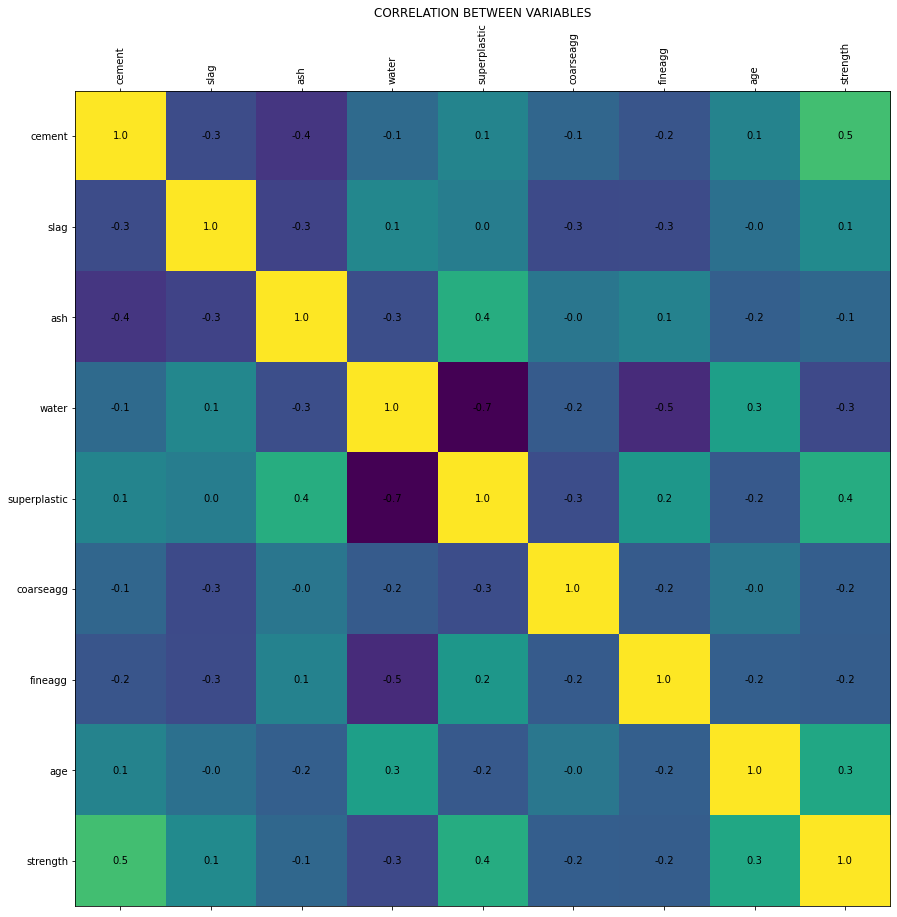

In [10]:
def plot_corr(df, size=15):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plot_corr(df)
plt.xticks(rotation = 90)
plt.title('CORRELATION BETWEEN VARIABLES', y = 1) 

<Figure size 720x432 with 0 Axes>

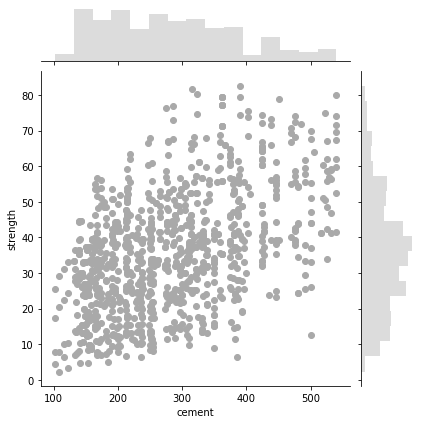

In [11]:
plt.figure(figsize=(10,6))
sns.jointplot(x=df["cement"], y=df["strength"],color='darkgray', kind='scatter')

plt.show()

<Figure size 720x432 with 0 Axes>

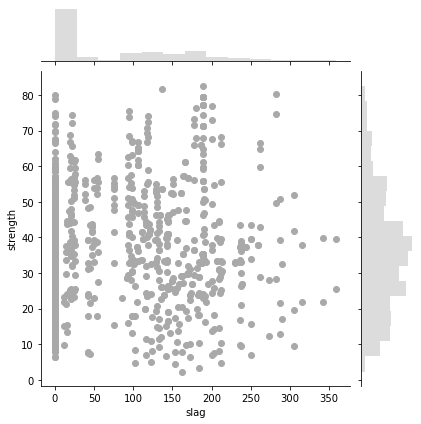

In [12]:
plt.figure(figsize=(10,6))
sns.jointplot(x=df["slag"], y=df["strength"],color='darkgray', kind='scatter')

plt.show()

<Figure size 720x432 with 0 Axes>

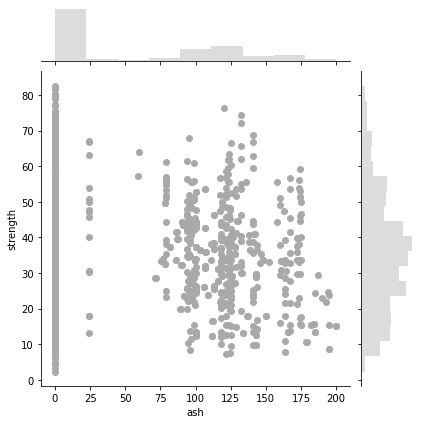

In [13]:
plt.figure(figsize=(10,6))
sns.jointplot(x=df["ash"], y=df["strength"],color='darkgray', kind='scatter')
plt.show()

<Figure size 720x432 with 0 Axes>

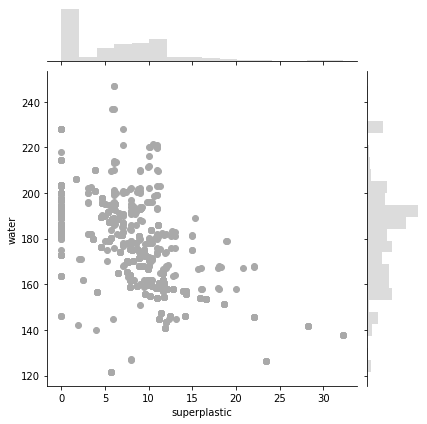

In [14]:
plt.figure(figsize=(10,6))
sns.jointplot(x=df["superplastic"], y=df["water"],color='darkgray', kind='scatter')
plt.show()

Description:
    
According to the pair plot, slag and ash have a slight negative correlation with cement. While strength is positively correlated with cement. There is a strong negative correlation between water and superplastic and water and fineagg. Superplastic and strength have a strong positive correlation.


#### Feature Engineering Technique

In [15]:
################## add list of R square values #####################
df.corr()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
ash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
superplastic,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
coarseagg,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
fineagg,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


Based on the correlation values above there seems to be a small correlation between water, superplastic, and coarsegg and age but because I do notice correlation between those attributes, I shouldn't drop any. The follow attributes have a value greater than 0.3 r-square, slag and ash, slag and coarseagg, slag and fineagg, ash and water, ash and superplastic, water and superplastic, water and fineagg. I'll be adding those cross attributes to the model.

In [16]:
################# Add ratio variables #####################
df['coarseagg_fineagg'] = df['coarseagg'] / df['fineagg']
df['slag_ash'] = df['slag'] / df['ash']
df['slag_coarseagg'] = df['slag'] / df['coarseagg']
df['slag_fineagg'] = df['slag'] / df['fineagg']
df['ash_superplastic'] = df['ash'] / df['superplastic']
df['water_superplastic'] = df['water'] / df['superplastic']
df['ash_water'] = df['ash'] / df['water']
df['finagg_water'] = df['fineagg'] / df['water']
df['water_cement'] = df['water']/df['cement']

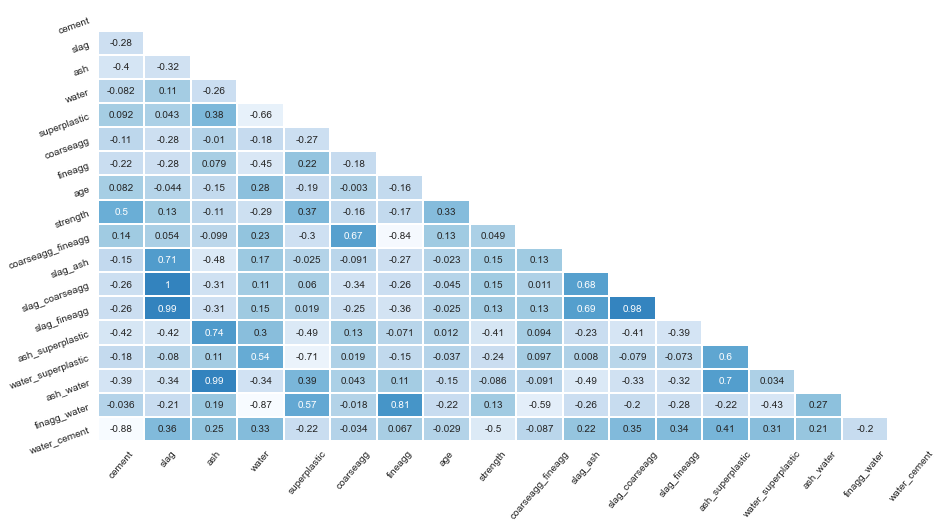

In [17]:
corr = df.corr()
lower_triangle = np.tril(corr, k = -1) 
mask = lower_triangle == 0  

plt.figure(figsize = (15,8))
sns.set_style(style = 'white')
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

Out of all the added ratio variables, only water_cement have good correlation with strength. I will drop the rest of the ratio variables. I will also drop cement and water, since I have the info with the ratio variable.

In [18]:
df = df.drop(['cement','water','coarseagg_fineagg', 'finagg_water', 'ash_water','water_superplastic',
             'slag_fineagg', 'slag_ash', 'slag_coarseagg', 'ash_superplastic'],axis=1)

In [19]:
############## Re arrange columns #############
df = df[['slag', 'coarseagg',
       'fineagg', 'age', 'water_cement', 'ash', 'superplastic', 'strength']]
df.head()

,slag,coarseagg,fineagg,age,water_cement,ash,superplastic,strength
0,212.0,971.8,748.5,28,1.440198,0.0,0.0,29.89
1,42.2,1080.8,796.2,14,0.937241,124.3,10.8,23.51
2,0.0,956.9,861.2,28,0.749600,95.7,5.5,29.22
3,114.0,932.0,670.0,28,0.857143,0.0,0.0,45.85
4,183.4,1047.4,696.7,28,1.248708,0.0,9.1,18.29


In [20]:
#################### Fix outliers ############################
##################### Impute mean value for normal distribution and impute mediean for non-nomrla distribution ###########
df_T = df
upper_age =df['age'].quantile(0.75)+1.5*(df['age'].quantile(0.75)-df['age'].quantile(0.25))

df_T["age"] = np.where(df_T["age"] > upper_age, df['age'].quantile(0.5),df_T['age'])


upper_fineagg =df['fineagg'].quantile(0.75)+1.5*(df['fineagg'].quantile(0.75)-df['fineagg'].quantile(0.25))

df_T["fineagg"] = np.where(df_T["fineagg"] > upper_fineagg, df['fineagg'].quantile(0.5),df_T['fineagg'])

upper_superplastic =df['superplastic'].quantile(0.75)+1.5*(df['superplastic'].quantile(0.75)-df['superplastic'].quantile(0.25))

df_T["superplastic"] = np.where(df_T["superplastic"] > upper_superplastic, df['superplastic'].quantile(0.5),df_T['superplastic'])

upper_slag =df['slag'].quantile(0.75)+1.5*(df['slag'].quantile(0.75)-df['slag'].quantile(0.25))

df_T["slag"] = np.where(df_T["slag"] > upper_slag, df['slag'].quantile(0.5),df_T['slag'])


scaler = StandardScaler()

scaler = StandardScaler()
df_T[:] = scaler.fit_transform(df_T[:].to_numpy())
X = df_T.drop('strength',axis=1)
Y = df_T['strength']


In [21]:
#Split the data into training and test set in the ratio of 70:30 respectively. The target variable is Target.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1729)

print(extra['Bold'],extra['Blue'],extra['Underline'],"\n Training Shape")
print("\n")
print(extra['End'],x_train.shape)
print(extra['Bold'],extra['Blue'],extra['Underline'],"\n Test Shape")
print("\n")
print(extra['End'],x_test.shape)

   
 Training Shape


 (721, 7)
   
 Test Shape


 (309, 7)


In [22]:
############### Explore high degree models ###################

######Degree 1

model = DecisionTreeRegressor(random_state=seed)

model.fit(x_train,y_train)

print(round(model.score(x_train,y_train)*100, 3))

print(round(model.score(x_test,y_test)*100,3))

99.082
87.996


In [23]:
####### Degree 2

model_2 = Pipeline([
    ('poly',PolynomialFeatures(degree=2, interaction_only=True)),
    ('reg', DecisionTreeRegressor(random_state=seed))
])

model_2.fit(x_train,y_train)

print(round(model_2.score(x_train,y_train)*100, 3))

print(round(model_2.score(x_test,y_test)*100,3))

99.082
83.686


In [24]:
####### Degree 3

model_3 = Pipeline([
    ('poly',PolynomialFeatures(degree=3, interaction_only=True)),
    ('reg', DecisionTreeRegressor(random_state=seed))
])

model_3.fit(x_train,y_train)

print(round(model_3.score(x_train,y_train)*100, 3))

print(round(model_3.score(x_test,y_test)*100,3))

99.082
76.759


Degree one has the highest test score, so moving forward with degree one.

## Creating models and tuning them

### Build Models

#### Model 1 Lasso Regression

In [25]:
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)
for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for slag is 0.29551350853599745
The coefficient for coarseagg is -0.08502523880408014
The coefficient for fineagg is -0.11131537699375757
The coefficient for age is 0.4834420687434775
The coefficient for water_cement is -0.5862721516886721
The coefficient for ash is 0.031219297806575626
The coefficient for superplastic is 0.1708835720930394


In [26]:
########### Use Lasso method to reduce dimentions   #############
lasso = Lasso(alpha=0.001)
lasso.fit(x_train,y_train)
#print ("Lasso model:", (lasso.coef_))
for idx, col_name in enumerate(x_train.columns):
    print("The coefficient for {} is {}".format(col_name, lasso.coef_[idx]))


The coefficient for slag is 0.2920790013364195
The coefficient for coarseagg is -0.08450296210106413
The coefficient for fineagg is -0.11131035101920872
The coefficient for age is 0.48233802397427905
The coefficient for water_cement is -0.5828057318817172
The coefficient for ash is 0.027466942927257546
The coefficient for superplastic is 0.17251015892103527


In [27]:
print(lasso.score(x_train, y_train))
print(lasso.score(x_test, y_test))

0.663152349990527
0.6989847450425217


In [28]:

kfold = KFold(n_splits=10, random_state=1729)
model = LinearRegression()
results = cross_val_score(model, X, Y, cv=kfold, scoring = 'r2')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.61274056 0.66343603 0.72763509 0.61554602 0.64413145 0.67501534
 0.67436595 0.65690437 0.6795885  0.64839948]
Accuracy: 65.978% (3.163%)


In [29]:
model = {"Method": "Lasso",
           "Training score" : [round(lasso.score(x_train, y_train)*100,1)],
              "Testing score": [round(lasso.score(x_test, y_test)*100,1)],
        "Kfold Accuracy" : [results.mean()*100.0],
        "Kfold Margin of error" : [results.std()*100.0],}
model1 = pd.DataFrame(data=model)

#### Model 2 Bagging

In [30]:
regressor = RandomForestRegressor(n_estimators = 100 , random_state=1729) 
regressor.fit(x_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1729, verbose=0, warm_start=False)

In [31]:
print(regressor.score(x_train, y_train))
print(regressor.score(x_test, y_test))


0.9774615760700536
0.9282934964448833


In [32]:
kfold = KFold(n_splits=10, random_state=1729)
model2 = RandomForestRegressor(n_estimators = 100 , random_state=1729) 
results = cross_val_score(model2, X, Y, cv=kfold, scoring = 'r2')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.84726464 0.90446843 0.94436355 0.92523466 0.89746866 0.93648753
 0.92597658 0.91240252 0.91054262 0.91799641]
Accuracy: 91.222% (2.552%)


In [33]:
model = {"Method": "Bagging",
           "Training score" : [round(regressor.score(x_train, y_train)*100,1)],
              "Testing score": [round(regressor.score(x_test, y_test)*100,1)],
        "Kfold Accuracy" : [results.mean()*100.0],
        "Kfold Margin of error" : [results.std()*100.0],}
model2 = pd.DataFrame(data=model)

#### Model 3 Boosting

In [34]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 100, learning_rate=0.3, random_state=1729)
reg.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1729, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))


0.9712959920680697
0.9421719950065757


In [36]:
kfold = KFold(n_splits=10, random_state=1729)
model3 = ensemble.GradientBoostingRegressor(n_estimators = 100, learning_rate=0.3, random_state=1729)
results = cross_val_score(model3, X, Y, cv=kfold, scoring = 'r2')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.89919337 0.90063976 0.94526181 0.92239423 0.89839379 0.9344961
 0.92360405 0.94014065 0.9302008  0.90451907]
Accuracy: 91.988% (1.700%)


In [37]:
model = {"Method": "Boosting",
           "Training score" : [round(reg.score(x_train, y_train)*100,1)],
              "Testing score": [round(reg.score(x_test, y_test)*100,1)],
        "Kfold Accuracy" : [results.mean()*100.0],
        "Kfold Margin of error" : [results.std()*100.0],}
model3 = pd.DataFrame(data=model)

#### Model 3 Boosting 2

In [38]:
reg2 = ensemble.GradientBoostingRegressor(n_estimators = 1000, learning_rate=0.1, random_state=1729)
reg2.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1729, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
print(reg2.score(x_train, y_train))
print(reg2.score(x_test, y_test))

0.9859661858324293
0.9460564812929316


In [40]:
kfold = KFold(n_splits=10, random_state=1729)
model4 = ensemble.GradientBoostingRegressor(n_estimators = 1000, learning_rate=0.1, random_state=1729)
results = cross_val_score(model4, X, Y, cv=kfold, scoring = 'r2')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.9179449  0.92191204 0.95284487 0.94092515 0.91333352 0.94649145
 0.92846871 0.95683932 0.94733688 0.9296155 ]
Accuracy: 93.557% (1.454%)


In [41]:
model = {"Method": "Boosting 2",
           "Training score" : [round(reg.score(x_train, y_train)*100,1)],
              "Testing score": [round(reg.score(x_test, y_test)*100,1)],
        "Kfold Accuracy" : [results.mean()*100.0],
        "Kfold Margin of error" : [results.std()*100.0],}
model4 = pd.DataFrame(data=model)

#### Compaire all four methods

In [42]:
##############################################################
###  Make a DataFrame to compare models and their metrics  ###
##############################################################

fram = [model1, model2, model3, model4]

frams = pd.concat(fram)

frams

,Method,Training score,Testing score,Kfold Accuracy,Kfold Margin of error
0,Lasso,66.3,69.9,65.977628,3.163374
0,Bagging,97.7,92.8,91.222056,2.552224
0,Boosting,97.1,94.2,91.988436,1.700238
0,Boosting 2,97.1,94.2,93.557124,1.454218


For now Boosting 2 is the best model and meets the objective's criteria of r-square between 80% to 95%.

### Squeeze Extra Performance out of the Model

#### Model 1 Boosting

In [43]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])


grid2 = GridSearchCV(estimator = ensemble.GradientBoostingRegressor(n_estimators = 100, learning_rate=0.3, random_state=1729),  param_grid = dict(alpha=alphas), n_jobs = 32) 

grid2.fit(x_train, y_train) 


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.3,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

In [44]:
print(" Best cross-validation accuracy: {:.2f}". format( grid2.best_score_)) 
print(" Best parameters: ", grid2.best_params_) 
print(" Test set accuracy: {:.2f}". format( grid2.score(x_test, y_test)*100.0))

 Best cross-validation accuracy: 0.89
 Best parameters:  {'alpha': 0.1}
 Test set accuracy: 94.22


In [45]:
kfold = KFold(n_splits=10, random_state=1729)
#model3 = ensemble.GradientBoostingRegressor(n_estimators = 100, learning_rate=0.3, random_state=1729)
results = cross_val_score(grid2, X, Y, cv=kfold, scoring = 'r2')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.89919337 0.90063976 0.94526181 0.92239423 0.89839379 0.9344961
 0.92360405 0.94014065 0.9302008  0.90451907]
Accuracy: 91.988% (1.700%)


In [46]:
model = {"Method": "Boosting",
           "Best cross-validation accuracy" : [round(grid2.best_score_*100.0,1)],
              "Test set accuracy": [round(grid2.score(x_test, y_test)*100.0,1)],
        "Kfold Accuracy" : [round(results.mean()*100.0,1)],
        "Kfold Margin of error" : [round(results.std()*100.0,1)]}
model_1 = pd.DataFrame(data=model)


#### Model 2 Boosting 2

In [47]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])


grid3 = GridSearchCV(estimator = ensemble.GradientBoostingRegressor(n_estimators = 1000, learning_rate=0.1, random_state=seed),  param_grid = dict(alpha=alphas), n_jobs = 32) 

grid3.fit(x_train, y_train) 

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000,
                                                 n_iter_no_change=None,
             

In [48]:
print(" Best cross-validation accuracy: {:.2f}". format( grid3.best_score_)) 
print(" Best parameters: ", grid3.best_params_) 
print(" Test set accuracy: {:.2f}". format( grid3.score(x_test, y_test)*100.0))

 Best cross-validation accuracy: 0.89
 Best parameters:  {'alpha': 0.1}
 Test set accuracy: 94.61


In [49]:
kfold = KFold(n_splits=10, random_state=1729)

results = cross_val_score(grid3, X, Y, cv=kfold, scoring = 'r2')
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.9179449  0.92191204 0.95284487 0.94092515 0.91333352 0.94649145
 0.92846871 0.95683932 0.94733688 0.9296155 ]
Accuracy: 93.557% (1.454%)


In [50]:
model = {"Method": "Boosting 2",
           "Best cross-validation accuracy" : [round(grid3.best_score_*100.0,1)],
              "Test set accuracy": [round(grid3.score(x_test, y_test)*100.0,1)],
        "Kfold Accuracy" : [round(results.mean()*100.0,1)],
        "Kfold Margin of error" : [round(results.std()*100.0,1)]}
model_2 = pd.DataFrame(data=model)


#### Compairing the two methods

In [51]:
##############################################################
###  Make a DataFrame to compare models and their metrics  ###
##############################################################

fram = [model_1, model_2]

frams = pd.concat(fram)

frams

,Method,Best cross-validation accuracy,Test set accuracy,Kfold Accuracy,Kfold Margin of error
0,Boosting,88.6,94.2,92.0,1.7
0,Boosting 2,89.1,94.6,93.6,1.5


Conclusion:

Using GridSearch I was able to improve my Boosting 2 model a little more.
